In [ ]:
import os
import time
import subprocess

from PIL import Image
from torch.utils.data import Dataset, random_split
import scipy.io

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2, style='whitegrid')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! wget --directory-prefix=downloads http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.zip

--2022-05-15 20:02:53--  http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.zip
Resolving calvin.inf.ed.ac.uk (calvin.inf.ed.ac.uk)... 129.215.202.26
Connecting to calvin.inf.ed.ac.uk (calvin.inf.ed.ac.uk)|129.215.202.26|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.zip [following]
--2022-05-15 20:02:54--  https://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.zip
Connecting to calvin.inf.ed.ac.uk (calvin.inf.ed.ac.uk)|129.215.202.26|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://calvin-vision.net/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.zip [following]
--2022-05-15 20:02:55--  https://calvin-vision.net/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.zip
Resolving calvin-vision.net (calvin-vision.net)... 66

In [ ]:
dataset_path = 'COCOStuff10k/'

In [ ]:
! unzip downloads/cocostuff-10k-v1.1.zip -d '$dataset_path'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: COCOStuff10k/images/COCO_train2014_000000050806.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000221200.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000139198.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000067573.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000182317.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000104330.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000340898.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000275837.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000407700.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000088282.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000084731.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000398808.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000347445.jpg  
  inflating: COCOStuff10k/images/COCO_train2014_000000497768.

In [ ]:
img_path = dataset_path + 'images/'
mask_path = dataset_path + 'annotations/'

In [ ]:
def one_hot_encode(label, label_values=torch.arange(183)):
    semantic_map = []
    for colour in label_values:
        equality = torch.eq(label, colour)
        semantic_map.append(equality)
    semantic_map = torch.stack(semantic_map, dim=-1)

    return semantic_map

def reverse_one_hot(image):
    x = torch.argmax(image.int(), dim=-1)
    return x

In [ ]:
class COCOStuff10kDataset(Dataset):
    """ 
    COCOStuff10k features dataset.
    """

    def __init__(self, dataset_path : str, input_size : tuple = (160, 240),
                 split : str = 'train') -> None:
        """
        Args:
            data_path: путь до изображений.
            mask_path: путь до масок изображений.
        """

        self.data_path = dataset_path + 'images/'
        self.mask_path = dataset_path + 'annotations/'
        self.split_info_path = dataset_path + 'imageLists/'
        self.label_values = torch.arange(183)


        # Файлы с изображениями и масками
        if split=='train':
            filenames = open(self.split_info_path+"train.txt", "r").readlines()
        elif split=='test':
            filenames = open(self.split_info_path+"test.txt", "r").readlines()
        else:
            raise ValueError("argument split must be 'test' or 'train'") 

        self.files = list(map(lambda x : x[:-1]+'.jpg', filenames))
        self.mask_files = list(map(lambda x : x[:-1]+'.mat', filenames))

        # Кэш файлы с изображениями и масками
        self.cache_image = [0] * len(self.files)
        self.cache_mask = [0] * len(self.mask_files)
        self.is_cached = [False] * len(self.files)

        assert len(self.files) == len(self.mask_files)

        # Преобразование для изображений
        self.transform = transforms.Compose([                                
            transforms.Resize(input_size),
            transforms.ToTensor(),
        ])
        # Преобразование для масок
        self.transform_mask = transforms.Compose([
            transforms.ToPILImage(),
            self.transform,
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if not self.is_cached[idx]:
            # Загружаем изображение и маску
            file_name = os.path.join(self.data_path, self.files[idx])
            mask_name = os.path.join(self.mask_path, self.mask_files[idx])
            
            # Пробразуем изображение и маску
            input = self.transform(Image.open(file_name).convert('RGB'))
            target = (self.transform_mask(scipy.io.loadmat(mask_name)['S']).squeeze()*255).int()
            one_hot_target = one_hot_encode(target, self.label_values).permute((2, 0, 1))

            # Кэшируем
            self.cache_image[idx] = input
            self.cache_mask[idx] = target
            self.is_cached[idx] = True
        else:
            input = self.cache_image[idx]
            target = self.cache_mask[idx]
            one_hot_target = one_hot_encode(target, self.label_values).permute((2, 0, 1))


        return input, one_hot_target

In [ ]:
train_dataset = COCOStuff10kDataset(dataset_path, split='train')
test_dataset = COCOStuff10kDataset(dataset_path, split='test')

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

In [ ]:
img_batch, mask_batch = next(iter(train_dataloader))

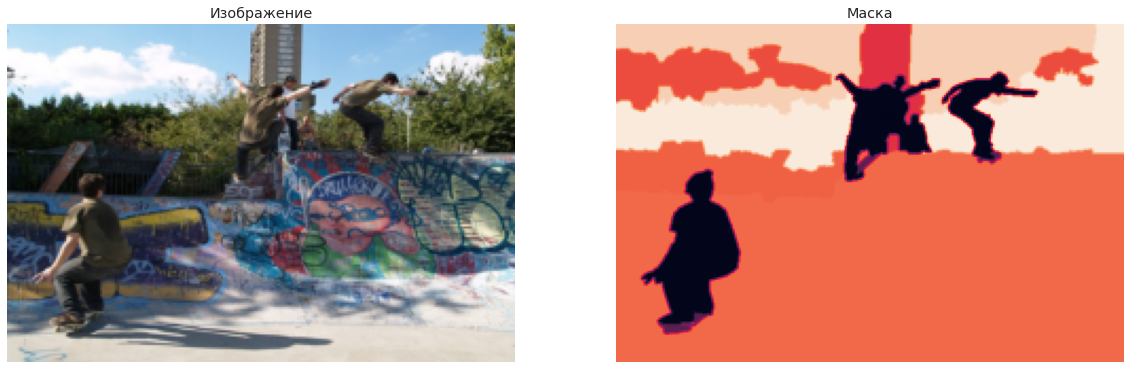

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(img_batch[0].permute((1, 2, 0)))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(reverse_one_hot(mask_batch[0].permute((1, 2, 0))))
plt.axis("off")

plt.show()

### Модель

In [ ]:
def conv_bn(in_channels, out_channels, kernel_size=3, stride=1, padding=0):
    net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 
                  kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(num_features=out_channels)
    )
    return net

def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=0):
    net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 
                  kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )
    return net

class ResNetBottleNeckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResNetBottleNeckBlock, self).__init__()
        self.constriction = 4

        self.constriction_channels = in_channels // self.constriction
        
        self.blocks = nn.Sequential(
            conv_bn_relu(in_channels, self.constriction_channels, kernel_size=1),
            conv_bn_relu(self.constriction_channels, self.constriction_channels,
                         kernel_size=kernel_size, stride=stride, padding=padding),
            conv_bn(self.constriction_channels, out_channels, kernel_size=1),
        )
        
        self.shortcut = conv_bn(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = x
        residual = self.shortcut(x)
        
        x = self.blocks(x)
        x += residual
        
        x = F.relu(x)
        return x

In [ ]:
class DepthwiseConv2d(torch.nn.Conv2d):
    def __init__(self,
                 in_channels,
                 depth_multiplier=1,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1,
                 bias=True,
                 padding_mode='zeros'
                 ):
        out_channels = in_channels * depth_multiplier
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=bias,
            padding_mode=padding_mode
        )


def MobileNetBlock(in_channels, out_channels, kernel=3, stride=1, padding=1):
    net = nn.Sequential(
        DepthwiseConv2d(in_channels, depth_multiplier=out_channels//in_channels, 
                  kernel_size=kernel, stride=stride, padding=padding),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 
                  kernel_size=1),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )
    return net


In [ ]:
class Stacked2Block(nn.Module):
    def __init__(self, in_channels, out_channels, block='standart'):
        super(Stacked2Block, self).__init__()
        
        if block == 'resnet':
            self.blocks = nn.Sequential(
                conv_bn_relu(in_channels, out_channels, padding=1), 
                ResNetBottleNeckBlock(out_channels, out_channels)
            )
        elif block == 'mobilenet':
            self.blocks = nn.Sequential(
                conv_bn_relu(in_channels, out_channels, padding=1), 
                MobileNetBlock(out_channels, out_channels)
            )
        elif block == 'standart':
            self.blocks = nn.Sequential(
                conv_bn_relu(in_channels, out_channels, padding=1), 
                conv_bn_relu(out_channels, out_channels, padding=1)
            )

    def forward(self, net):
        net = self.blocks(net)
        return net


class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, block='standart'):
        super(UpSamplingBlock, self).__init__()

        # Понижаем число каналов
        self.upsample = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=2, stride=2)
        
        # Стакаем с симметричным слоем из левой половины "U".
        # Число каналов входной карты при этом удваивается.
        self.convolve = Stacked2Block(2 * in_channels, out_channels, block=block)

    def forward(self, left_net, right_net):
        right_net = self.upsample(right_net)
        net = torch.cat([left_net, right_net], dim=1)
        net = self.convolve(net)
        return net

    
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, block='standart'):
        super(DownSamplingBlock, self).__init__()
        self.blocks = nn.Sequential(
            nn.MaxPool2d(2, 2),
            Stacked2Block(in_channels, out_channels, block=block)
        )

    def forward(self, net):
        return self.blocks(net)


class Unet(nn.Module):
    def __init__(self, num_classes=91+91+1, block='standart'):
        super(Unet, self).__init__()
        self.init_conv = Stacked2Block(3, 32)

        self.downsample_1 = DownSamplingBlock(32, 64, block)
        self.downsample_2 = DownSamplingBlock(64, 128, block)
        self.downsample_3 = DownSamplingBlock(128, 256, block)
        self.downsample_4 = DownSamplingBlock(256, 512, block)
         
        # В середине есть блок без пары с 512 каналами
        # с ним конкатенировать некого, потому просто свернём его        
        self.upconv = Stacked2Block(512, 256, block)
        
        # Подъём. Аналогично.

        self.upsample_1 = UpSamplingBlock(256, 128, block)
        self.upsample_2 = UpSamplingBlock(128, 64, block)
        self.upsample_3 = UpSamplingBlock(64, 32, block)
        # Чтобы учесть входной слой после самой первой свёртки
        # и согласовать размерности
        self.upsample_4 = UpSamplingBlock(32, 32, block)
        
        # Предсказание
        self.agg_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        net0 = self.init_conv(x) # 3 --> 32
       
        net1 = self.downsample_1(net0) # 32 --> 64
        net2 = self.downsample_2(net1) # 64 --> 128
        net3 = self.downsample_3(net2) # 128 --> 256
        net = self.downsample_4(net3) # 256 --> 512
        
        net = self.upconv(net) # 512 --> 256
        
        net = self.upsample_1(net3, net) # 256 --> 128
        net = self.upsample_2(net2, net) # 128 --> 64
        net = self.upsample_3(net1, net) # 64 --> 32
        net = self.upsample_4(net0, net) # 32 --> 32
        
        net = self.agg_conv(net) # 32 --> 183

        return net
        

In [ ]:
def DSC(predicted_mask_channel, target_mask_channel):
    """ Считает Dice Score для одного канала """
    # Площадь пересечения в пикселях
    intersection = (predicted_mask_channel & target_mask_channel).sum(dim=(1, 2))
    # Сумма площадей в пикселях
    sum = (predicted_mask_channel).sum(dim=(1, 2)) + target_mask_channel.sum(dim=(1, 2))
    DSC = (2 * intersection / sum).mean()
    return DSC

def mDSC(predicted_mask_batch, target_mask_batch):
    """ 
    Считает Dice Score для всех классов батча 
    : input_shape = (batch_size, width, height, n_channels)
    """

    n_channels = predicted_mask_batch.shape[1]
    n_classes = 0
    mDSC = 0.

    for channel in range(1, n_channels):
        predicted_mask_channel = predicted_mask_batch[:, :, :, channel]
        target_mask_channel = target_mask_batch[:, :, :, channel]
        
        dsc = DSC(predicted_mask_channel, target_mask_channel)
        if not torch.isnan(dsc).item():
            n_classes += 1

        mDSC += torch.nan_to_num(dsc)
    
    mDSC /= n_classes

    return mDSC

In [ ]:
def train(
        segment_model,
        optimizer,
        criterion,
        train_dataloader,
        val_dataloader,
        state_dict_path,
        device="cpu",
        n_epochs=20,
        show_interval=20,
        savefig_dir=None,
    ):

    # Set history
    history = {}
    history["train_loss"] = []
    history["train_mDSC"] = []
    history["val_loss"] = []
    history["val_mDSC"] = []

    # Set start epoch number
    start_epoch = 0

    # Load state dict
    if os.path.exists(state_dict_path):
        state = torch.load(state_dict_path)
        segment_model.load_state_dict(state["model"])
        optimizer.load_state_dict(state["optimizer"])
        history = state["history"]
        start_epoch = state["epoch"] + 1

    n_train_batches = len(train_dataloader)
    n_val_batches = len(val_dataloader)

    best_val_mDSC = 0.
    
    end_epoch = start_epoch + n_epochs

    if savefig_dir is not None:
        if not os.path.exists(savefig_dir):
            os.mkdir(savefig_dir)

    for epoch in range(start_epoch, start_epoch + n_epochs):

        print(f"Epoch {epoch}/{end_epoch}")

        segment_model.train()

        train_loss = 0.
        train_mDSC = 0.

        for i, (image, mask) in enumerate(tqdm(train_dataloader)):
            image = image.to(device)
            mask = mask.to(device)

            pred = segment_model(image)
            loss = criterion(pred, mask.float())
            loss.backward()

            if i == (n_train_batches - 1):
                optimizer.step()
                optimizer.zero_grad()

            loss_ = float(loss.detach().data)

            pred_labels = torch.argmax(F.softmax(pred.detach().permute((0, 2, 3, 1)), dim=-1), dim=-1)
            pred_labels = one_hot_encode(pred_labels)
            mDSC_ = float(mDSC(pred_labels, mask.permute((0, 2, 3, 1))).data)
            
            train_loss += loss_
            train_mDSC += mDSC_

        train_loss = train_loss / n_train_batches
        train_mDSC = train_mDSC / n_train_batches

        history["train_loss"].append(train_loss)
        history["train_mDSC"].append(train_mDSC)

        print('')
        print(f"Total Train:\tloss\t{train_loss:.5f}"
              f"\t\tmDSC\t{train_mDSC:.5f}")

        segment_model.eval()

        val_loss = 0.
        val_mDSC = 0. 

        with torch.no_grad():
            for image, mask in tqdm(val_dataloader):
                image, mask = image.to(device), mask.to(device)
                pred = segment_model(image)
                loss = criterion(pred, mask.float())
                loss_ = float(loss.data)

                pred_labels = torch.argmax(F.softmax(pred.permute((0, 2, 3, 1)), dim=-1), dim=-1)
                pred_labels = one_hot_encode(pred_labels)
                mDSC_ = float(mDSC(pred_labels, mask.permute((0, 2, 3, 1))).data)

                # print(f"Batch Valid:\tloss\t{loss_:.5f}"
                #       f"\t\tmDSC\t{mDSC_:.5f}")
                
                val_mDSC += mDSC_
                val_loss += loss_

        val_loss = val_loss / n_val_batches
        val_mDSC = val_mDSC / n_val_batches

        history["val_loss"].append(val_loss)
        history["val_mDSC"].append(val_mDSC)

        if history["val_mDSC"][-1] > best_val_mDSC:
            torch.save({
                "model": segment_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "history": history,
                "epoch": epoch,
            }, state_dict_path)
            best_val_mDSC = history["val_mDSC"][-1]

        print('')
        print(f"Toatal Valid:\tloss\t{val_loss:.5f}"
              f"\t\tmDSC\t{val_mDSC:.5f}"
              f"\t\tbest mDSC\t{best_val_mDSC:.5f}")
        print('-' * 100)

        clear_output(wait=True)

        if epoch % show_interval == show_interval - 1:

            # Отрисовка графиков
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(history["train_loss"], label='train')
            plt.plot(history["val_loss"], label='test')
            plt.title("Loss")
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(history["train_mDSC"], label='train')
            plt.plot(history["val_mDSC"], label='test')
            plt.title("mDSC")
            plt.legend();

            plt.show()
          
            # Отрисовка результатов
            n_img = 4

            plt.figure(figsize=(20, n_img * 3.5))

            for i, (image, mask) in enumerate(test_dataset):
                if i == n_img:
                    break
            
                plt.subplot(n_img, 3, 3 * i + 1)
                plt.imshow(image.permute(1, 2, 0).cpu())
                plt.axis("off")
                plt.title("Изображение")

                plt.subplot(n_img, 3, 3 * i + 2)
                plt.imshow(reverse_one_hot(mask.squeeze().cpu().permute((1, 2, 0))))
                plt.axis("off")
                plt.title("Реальная маска")

                with torch.no_grad():
                    pred = segment_model(image.unsqueeze(dim=0).to(device))\
                        .squeeze().cpu()
                    
                    pred_labels = torch.argmax(F.softmax(pred.permute((1, 2, 0)), dim=-1), dim=-1)
                    

                plt.subplot(n_img, 3, 3 * i + 3)
                plt.imshow(pred_labels)
                plt.axis("off")
                plt.title("Предсказанная маска")

            if savefig_dir is not None:
                plt.savefig(os.path.join(savefig_dir, f"results_epoch_{epoch:03d}.png"))
            plt.show()

In [ ]:
segment_model = Unet().to(device)
optimizer = torch.optim.Adam(segment_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
states_path = '/content/drive/MyDrive/Colab Notebooks/ABBYY SciDev/COCOStuff10k/'

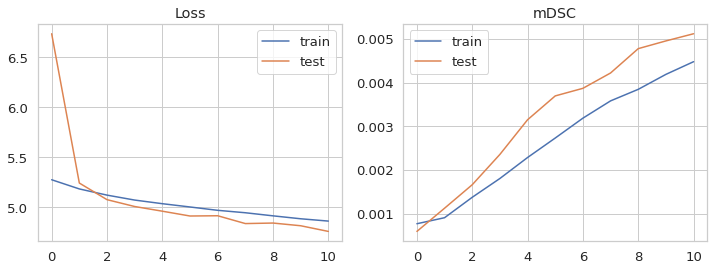

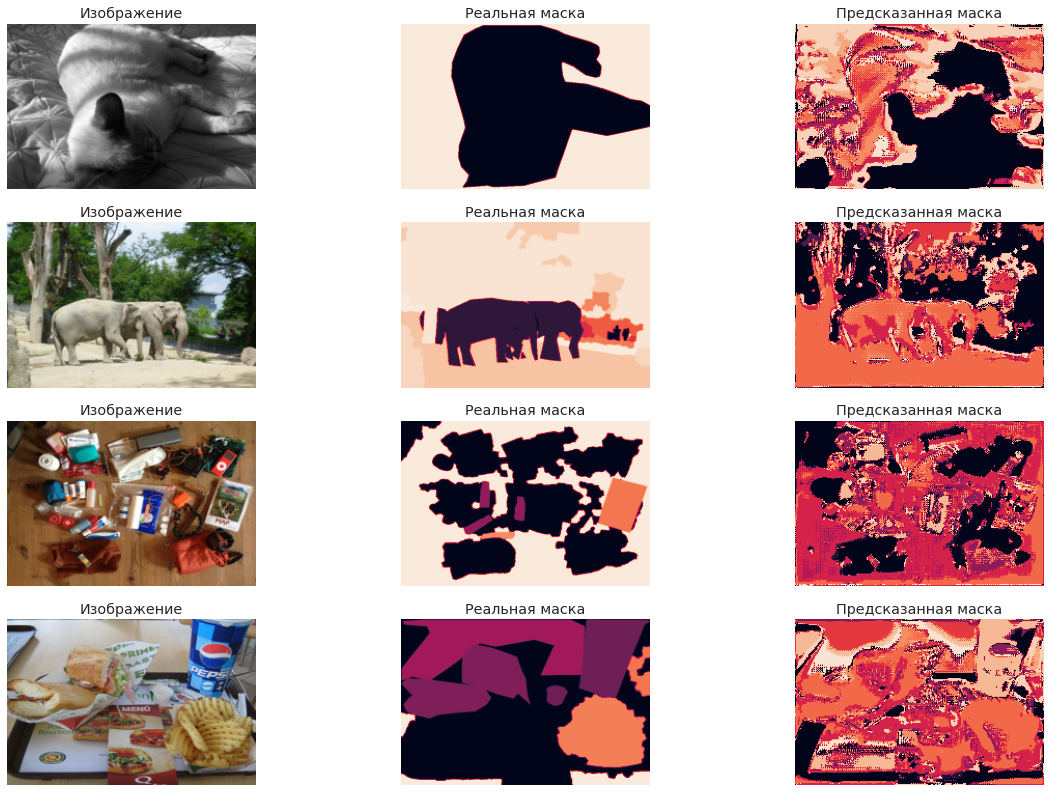

Epoch 11/58


  0%|          | 0/563 [00:00<?, ?it/s]

In [ ]:
state_dict_path = states_path + f'model states/mobileUnetStandart1.pt'
savefig_dir = states_path + 'result images/'

train(
    segment_model,
    optimizer,
    criterion,
    train_dataloader,
    test_dataloader,
    state_dict_path=state_dict_path,
    device=device,
    n_epochs=50,
    show_interval=1
)